# Final assignment - Task 3.
## Comparative Analysis of Epidemiological Models

**Author:** Pablo Rodríguez López
**Course**: Modelization and Simulation of Biosystem
**Masters**: Computational Biology
**University**: Polytechnic University of Madrid
**Date:** January 2026

---

## Task Description:

In this task, you will extend the classic predator-prey model.
* Modify the predator-prey system by adding a second predator that feeds on the same prey.
* Study two different scenarios:
   1. The second predator grows faster than Predator 1.
   2. The second predator dies faster than Predator 1.
* Analyze how the system dynamics change compared to the original model studied in class.
   *  How do the oscillations change?
   *  Are they stronger, weaker, more regular, or more complex?
* Perform a sensitivity analysis on your extended model.

---

## Notebook description:

This notebook extends the classic Lotka-Volterra predator-prey model by introducing a **second predator** ($P_2$) that feeds on the same prey ($H$) as the original predator ($P_1$). This introduces competition between the two predator species.

### Mathematical Model
The original system is described by a simple 2-ODE system:
$$
\begin{align*}
\frac{dH}{dt} &= aH - bH P \\\\
\frac{dP}{dt} &= cH P - dP
\end{align*}
$$


The system is described by the following set of ordinary differential equations (ODEs):
1. **Prey ($H$):** Grows exponentially, consumed by both predators.
2. **Predator 1 ($P_1$):** Consumes prey, dies naturally.
3. **Predator 2 ($P_2$):** Consumes prey, dies naturally.


$$
\begin{align*}
\frac{dH}{dt} &= a H - b_1 H P_1 - b_2 H P_2 \\\\
\frac{dP_1}{dt} &= c_1 H P_1 - d_1 P_1 \\\\
\frac{dP_2}{dt} &= c_2 H P_2 - d_2 P_2
\end{align*}
$$

**Parameters:**
* $a$: Prey growth rate
* $b_1, b_2$: Predation rates (attack efficiency)
* $c_1, c_2$: Predator growth rates (conversion efficiency)
* $d_1, d_2$: Predator death rates

We will analyze the dynamics under different scenarios to observe the **Principle of Competitive Exclusion**.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Sensitivity analysis
print(f"\nInstalling SALib package for sensitivity analysis\n")
!pip install SALib
from SALib.sample import saltelli
from SALib.analyze import sobol
print(f"\nSALib successfully installed\n")

plt.rcParams['figure.dpi'] = 120

# Print python and package versions
import sys
print("="*70)
print("SOFTWARE VERSIONS")
print("="*70)
print(f"\nPython version: {sys.version}")
print(f"numpy version: {np.__version__}")
import matplotlib
print(f"matplotlib version: {matplotlib.__version__}")
import scipy
print(f"scipy version: {scipy.__version__}")
print("="*70)

# Set random seed for reproducibility
np.random.seed(42)


Installing SALib package for sensitivity analysis


SALib successfully installed

SOFTWARE VERSIONS

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
numpy version: 2.0.2
matplotlib version: 3.10.0
scipy version: 1.16.3


## 1. Model Definition & Simulation Setup

In [21]:
def original_predator_prey(t, y, a, b, c, d):
    """
    Defines the ODE system for 1 Prey (H) and 1 Predators (P).
    """
    H, P = y

    # Differential Equations
    dHdt  = a * H - b * H * P
    dPdt = c * H * P - d * P

    return [dHdt, dPdt]

In [22]:
def extended_predator_prey(t, y, a, b1, b2, c1, c2, d1, d2):
    """
    Defines the ODE system for 1 Prey (H) and 2 Predators (P1, P2).
    """
    H, P1, P2 = y

    # Differential Equations
    dHdt  = a * H - b1 * H * P1 - b2 * H * P2
    dP1dt = c1 * H * P1 - d1 * P1
    dP2dt = c2 * H * P2 - d2 * P2

    return [dHdt, dP1dt, dP2dt]

In [23]:
def run_simulation(function, params, time_span=(0, 200), y0=[40, 9, 9]):
    """
    Helper function to run the simulation with specific parameters.
    """
    t_eval = np.linspace(time_span[0], time_span[1], 100*time_span[1])

    # Unpack parameters: a, b1, b2, c1, c2, d1, d2
    args = tuple(params)

    # Solve ODE
    if function == original_predator_prey:
      sol = solve_ivp(original_predator_prey, time_span, y0,
                      args=args, t_eval=t_eval, method='LSODA', rtol=1e-9, atol=1e-9)
    elif function == extended_predator_prey:
      sol = solve_ivp(extended_predator_prey, time_span, y0,
                      args=args, t_eval=t_eval, method='LSODA', rtol=1e-9, atol=1e-9)
    else:
      raise ValueError("Invalid function. Use original_predator_prey or extended_predator_prey.")
    return sol

## 2. Scenario Analysis

We investigate two scenarios compared to a baseline.

**Baseline Parameters:**
* $a=1.0$
* $b_1=0.1, c_1=0.075, d_1=1.5$
* $b_2=0.1$ (Assuming similar predation style initially)

### Scenario 1: Predator 2 grows faster than Predator 1
* We set $c_2 > c_1$, for instance $c_2 = 0.10$ vs $c_1 = 0.075$.
* P2 converts food to offspring more efficiently.
* We then leave death rate the same; $d_2 = 1.5$

### Scenario 2: Predator 2 dies faster than Predator 1
* We set $d_2 > d_1$, for instnace $d_2 = 2$ vs $d_1 = 1.5$.
* P2 has a higher mortality rate (shorter lifespan).
* We then leave growth rate the same: $c_2 = 0.075$

In [24]:
from math import e
# Initial Conditions: 40 Prey, 9 of each Predator
y0 = [40, 9, 9]

# --- DEFINE PARAMETERS [a, b1, b2, c1, c2, d1, d2] ---

# Scenario 1: P2 grows faster (Higher c2)
# P1: c=0.075 | P2: c=0.10
params_sc1 = [1.0, 0.1, 0.1, 0.075, 0.10, 1.5, 1.5]

# Scenario 2: P2 dies faster (Higher d2)
# P1: d=0.5 | P2: d=0.7
params_sc2 = [1.0, 0.1, 0.1, 0.075, 0.075, 1.5, 2]

# Run Simulations
tmax = 50
sol1 = run_simulation(extended_predator_prey, params_sc1, time_span=(0,50), y0=y0)
sol2 = run_simulation(extended_predator_prey, params_sc2, time_span=(0,50), y0=y0)

In [25]:
# ----------------------------------------
# PLOTING CONFIGURATION
# ----------------------------------------

# --- GLOBAL FONT SETTINGS ---
TITLE_SIZE = 20
SUBTITLE_SIZE = 16
LABEL_SIZE = 14
TICK_SIZE = 12

# --- Calculate global axis limits (padding-based) ---
def get_padded_limits(data):
    """Calculates min/max with 5% padding based on the range."""
    d_min, d_max = data.min(), data.max()
    diff = d_max - d_min
    margin = diff / 20  # 1/20th of the range
    return d_min - margin, d_max + margin

# Column 1 (Time Course): Limits based on ALL populations
all_pops = np.concatenate([sol1.y.flatten(), sol2.y.flatten()])
c1_min, c1_max = get_padded_limits(all_pops)

# Column 2 (Prey vs Predators):
# X-axis: Prey
all_prey = np.concatenate([sol1.y[0], sol2.y[0]])
c2_xmin, c2_xmax = get_padded_limits(all_prey)
# Y-axis: All Predators
all_preds = np.concatenate([sol1.y[1], sol1.y[2], sol2.y[1], sol2.y[2]])
c2_ymin, c2_ymax = get_padded_limits(all_preds)

# Column 3 (P1 vs P2):
# X-axis: Predator 1
all_p1 = np.concatenate([sol1.y[1], sol2.y[1]])
c3_xmin, c3_xmax = get_padded_limits(all_p1)
# Y-axis: Predator 2
all_p2 = np.concatenate([sol1.y[2], sol2.y[2]])
c3_ymin, c3_ymax = get_padded_limits(all_p2)

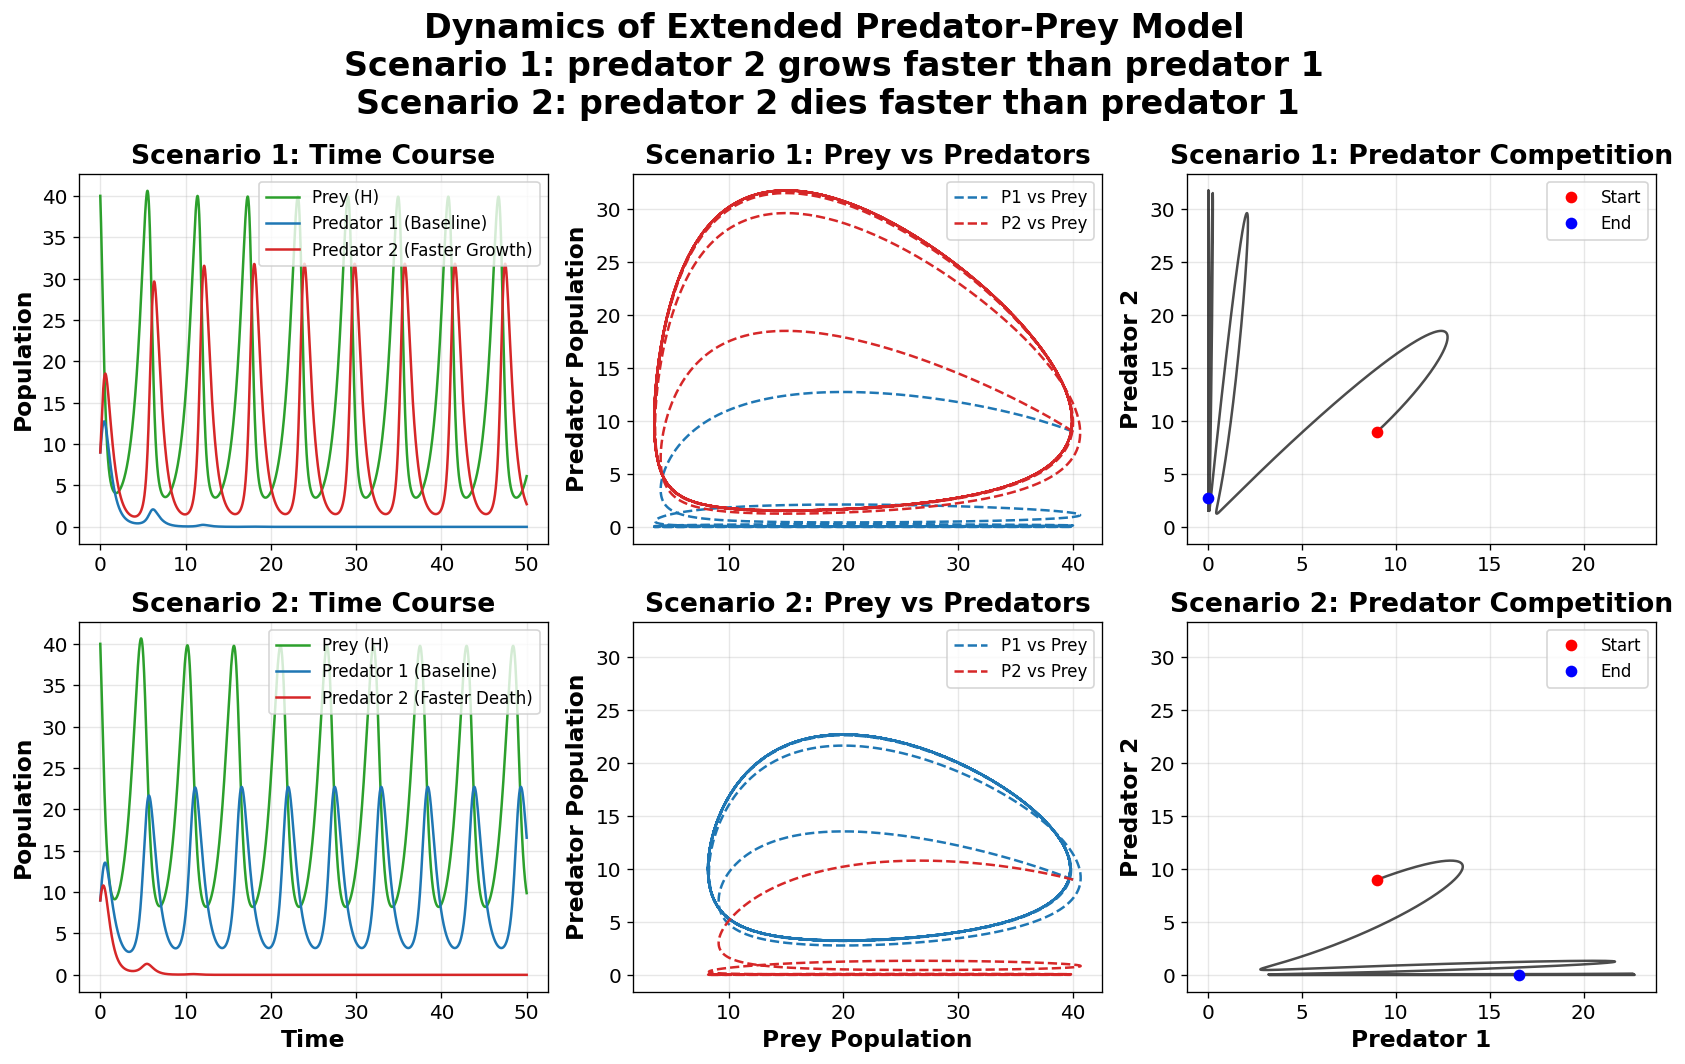

In [26]:
# Plotting Results
fig, axs = plt.subplots(2, 3, figsize=(14, 9))

# Main Figure Title
fig.suptitle(f"Dynamics of Extended Predator-Prey Model\nScenario 1: predator 2 grows faster than predator 1\nScenario 2: predator 2 dies faster than predator 1 ", fontsize=TITLE_SIZE, fontweight='bold')

# Helper function to apply styling
def style_ax(ax, title, xlabel, ylabel, show_xlabel=True, show_ylabel=True):
    ax.set_title(title, fontsize=SUBTITLE_SIZE, fontweight='bold')
    if show_xlabel:
        ax.set_xlabel(xlabel, fontsize=LABEL_SIZE, fontweight='bold')
    if show_ylabel:
        ax.set_ylabel(ylabel, fontsize=LABEL_SIZE, fontweight='bold')
    ax.tick_params(axis='both', labelsize=TICK_SIZE)
    ax.grid(alpha=0.3)

# ----------------------------------------
# SCENARIO 1 (ROW 0) - P2 Grows Faster
# ----------------------------------------

# 1. Time Course
axs[0, 0].plot(sol1.t, sol1.y[0], '-', color='tab:green', label='Prey (H)')
axs[0, 0].plot(sol1.t, sol1.y[1], '-', color='tab:blue', label='Predator 1 (Baseline)')
axs[0, 0].plot(sol1.t, sol1.y[2], '-', color='tab:red', label='Predator 2 (Faster Growth)')
style_ax(axs[0, 0], 'Scenario 1: Time Course', 'Time', 'Population', show_xlabel=False)
axs[0, 0].set_ylim(c1_min, c1_max)
axs[0, 0].legend(loc='upper right')

# 2. Phase Plane: Prey vs Predators (NEW)
# X-axis: Prey, Y-axis: Predators
axs[0, 1].plot(sol1.y[0], sol1.y[1], '--', color='tab:blue', label='P1 vs Prey')
axs[0, 1].plot(sol1.y[0], sol1.y[2], '--', color='tab:red', label='P2 vs Prey')
style_ax(axs[0, 1], 'Scenario 1: Prey vs Predators', 'Prey Population', 'Predator Population', show_xlabel=False)
axs[0, 1].set_xlim(c2_xmin, c2_xmax)
axs[0, 1].set_ylim(c2_ymin, c2_ymax)
axs[0, 1].legend()

# 3. Phase Plane: P1 vs P2
axs[0, 2].plot(sol1.y[1], sol1.y[2], 'k-', alpha=0.7)
axs[0, 2].plot(sol1.y[1][0], sol1.y[2][0], 'ro', label='Start')
axs[0, 2].plot(sol1.y[1][-1], sol1.y[2][-1], 'bo', label='End')
style_ax(axs[0, 2], 'Scenario 1: Predator Competition', 'Predator 1', 'Predator 2', show_xlabel=False)
axs[0, 2].set_xlim(c3_xmin, c3_xmax)
axs[0, 2].set_ylim(c3_ymin, c3_ymax)
axs[0, 2].legend()


# ----------------------------------------
# SCENARIO 2 (ROW 1) - P2 Dies Faster
# ----------------------------------------

# 1. Time Course
axs[1, 0].plot(sol2.t, sol2.y[0], '-', color='tab:green', label='Prey (H)')
axs[1, 0].plot(sol2.t, sol2.y[1], '-', color='tab:blue', label='Predator 1 (Baseline)')
axs[1, 0].plot(sol2.t, sol2.y[2], '-', color='tab:red', label='Predator 2 (Faster Death)')
style_ax(axs[1, 0], 'Scenario 2: Time Course', 'Time', 'Population', show_xlabel=True)
axs[1, 0].set_ylim(c1_min, c1_max)
axs[1, 0].legend(loc='upper right')

# 2. Phase Plane: Prey vs Predators (NEW)
axs[1, 1].plot(sol2.y[0], sol2.y[1], '--', color='tab:blue', label='P1 vs Prey')
axs[1, 1].plot(sol2.y[0], sol2.y[2], '--', color='tab:red', label='P2 vs Prey')
style_ax(axs[1, 1], 'Scenario 2: Prey vs Predators', 'Prey Population', 'Predator Population', show_xlabel=True)
axs[1, 1].set_xlim(c2_xmin, c2_xmax)
axs[1, 1].set_ylim(c2_ymin, c2_ymax)
axs[1, 1].legend()

# 3. Phase Plane: P1 vs P2
axs[1, 2].plot(sol2.y[1], sol2.y[2], 'k-', alpha=0.7)
axs[1, 2].plot(sol2.y[1][0], sol2.y[2][0], 'ro', label='Start')
axs[1, 2].plot(sol2.y[1][-1], sol2.y[2][-1], 'bo', label='End')
style_ax(axs[1, 2], 'Scenario 2: Predator Competition', 'Predator 1', 'Predator 2', show_xlabel=True)
axs[1, 2].set_xlim(c3_xmin, c3_xmax)
axs[1, 2].set_ylim(c3_ymin, c3_ymax)
axs[1, 2].legend()

plt.tight_layout()
plt.subplots_adjust(top=0.83) # Adjust for main title
plt.show()


## 4. Comparing the dynamics with the original model

In [27]:
# --- 1. SIMULATE ORIGINAL MODEL ---
def original_predator_prey(t, y, a, b, c, d):
    H, P = y
    dHdt = a * H - b * H * P
    dPdt = c * H * P - d * P
    return [dHdt, dPdt]

# Parameters for Original Model
params_orig = (1.0, 0.1, 0.075, 1.5)
y0_orig = [40, 9] # Matches H0 and P0 from extended model
sol_orig_1 = run_simulation(original_predator_prey, params_orig, time_span=(0,tmax), y0=y0_orig)
y0_orig = [33, 9] # trying several runnings
sol_orig_2 = run_simulation(original_predator_prey, params_orig, time_span=(0,tmax), y0=y0_orig)
y0_orig = [25, 9] # trying several runnings
sol_orig_3 = run_simulation(original_predator_prey, params_orig, time_span=(0,tmax), y0=y0_orig)

In [28]:
# --- 2. CALCULATE GLOBAL LIMITS ---
def get_padded_limits(data):
    """Calculates min/max with 5% padding based on the range."""
    d_min, d_max = data.min(), data.max()
    diff = d_max - d_min
    margin = diff / 20  # 1/20th of the range
    return d_min - margin, d_max + margin

# Row 1 (Time Course): Limits based on ALL populations across all models
# Flattening all arrays to find global min/max
all_pops = np.concatenate([sol_orig_1.y.flatten(), sol_orig_2.y.flatten(), sol_orig_3.y.flatten(), sol1.y.flatten(), sol2.y.flatten()])
c1_min, c1_max = get_padded_limits(all_pops)

# Row 2 (Phase Plane):
# X-axis: Global Prey Limits
all_prey = np.concatenate([sol_orig_1.y[0], sol_orig_2.y[0], sol_orig_3.y[0], sol1.y[0], sol2.y[0]])
c2_xmin, c2_xmax = get_padded_limits(all_prey)

# Y-axis: Global Predator Limits (P1 from original + P1/P2 from extended)
all_preds = np.concatenate([sol_orig_1.y[1], sol_orig_2.y[1], sol_orig_3.y[1], sol1.y[1], sol1.y[2], sol2.y[1], sol2.y[2]])
c2_ymin, c2_ymax = get_padded_limits(all_preds)

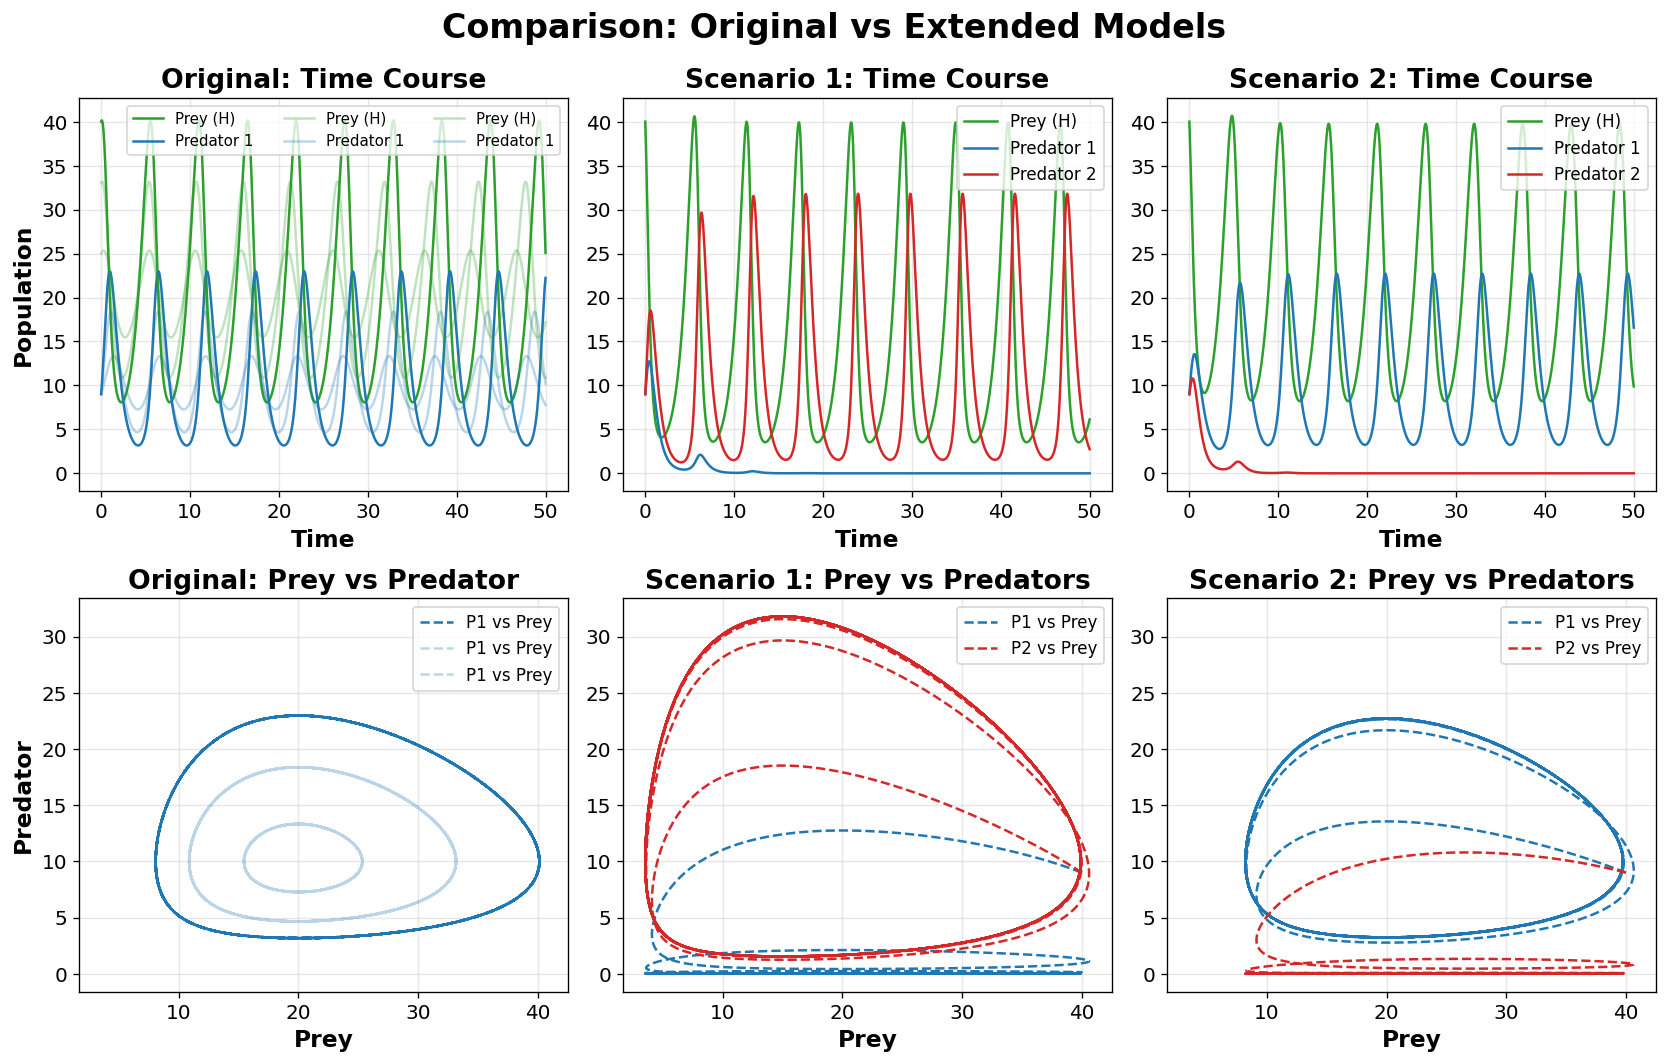

In [29]:
# --- 3. PLOTTING ---
fig, axs = plt.subplots(2, 3, figsize=(14, 9))

fig.suptitle("Comparison: Original vs Extended Models", fontsize=TITLE_SIZE, fontweight='bold')

# --- COLUMN 1: ORIGINAL MODEL ---
# Time Course
axs[0, 0].plot(sol_orig_1.t, sol_orig_1.y[0], '-', color='tab:green', label='Prey (H)')
axs[0, 0].plot(sol_orig_1.t, sol_orig_1.y[1], '-', color='tab:blue', label='Predator 1')
axs[0, 0].plot(sol_orig_2.t, sol_orig_2.y[0], '-', color='tab:green', label='Prey (H)', alpha=0.3)
axs[0, 0].plot(sol_orig_2.t, sol_orig_2.y[1], '-', color='tab:blue', label='Predator 1', alpha=0.3)
axs[0, 0].plot(sol_orig_3.t, sol_orig_3.y[0], '-', color='tab:green', label='Prey (H)', alpha=0.3)
axs[0, 0].plot(sol_orig_3.t, sol_orig_3.y[1], '-', color='tab:blue', label='Predator 1', alpha=0.3)
style_ax(axs[0, 0], 'Original: Time Course', 'Time', 'Population')
axs[0, 0].set_ylim(c1_min, c1_max)
axs[0, 0].legend(loc='upper right',ncols=3,fontsize=9)

# Phase Plane (Prey vs Predator)
axs[1, 0].plot(sol_orig_1.y[0], sol_orig_1.y[1], '--', color='tab:blue', label='P1 vs Prey')
axs[1, 0].plot(sol_orig_2.y[0], sol_orig_2.y[1], '--', color='tab:blue', label='P1 vs Prey', alpha=0.3)
axs[1, 0].plot(sol_orig_3.y[0], sol_orig_3.y[1], '--', color='tab:blue', label='P1 vs Prey', alpha=0.3)
style_ax(axs[1, 0], 'Original: Prey vs Predator', 'Prey', 'Predator')
axs[1, 0].set_xlim(c2_xmin, c2_xmax)
axs[1, 0].set_ylim(c2_ymin, c2_ymax)
axs[1, 0].legend(loc='upper right')


# --- COLUMN 2: SCENARIO 1 (Extended) ---
# Time Course
axs[0, 1].plot(sol1.t, sol1.y[0], '-', color='tab:green', label='Prey (H)')
axs[0, 1].plot(sol1.t, sol1.y[1], '-', color='tab:blue', label='Predator 1')
axs[0, 1].plot(sol1.t, sol1.y[2], '-', color='tab:red', label='Predator 2')
style_ax(axs[0, 1], 'Scenario 1: Time Course', 'Time', 'Population', show_ylabel=False)
axs[0, 1].set_ylim(c1_min, c1_max)
axs[0, 1].legend(loc='upper right')

# Phase Plane (Prey vs Predators)
axs[1, 1].plot(sol1.y[0], sol1.y[1], '--', color='tab:blue', label='P1 vs Prey')
axs[1, 1].plot(sol1.y[0], sol1.y[2], '--', color='tab:red', label='P2 vs Prey')
style_ax(axs[1, 1], 'Scenario 1: Prey vs Predators', 'Prey', 'Predator', show_ylabel=False)
axs[1, 1].set_xlim(c2_xmin, c2_xmax)
axs[1, 1].set_ylim(c2_ymin, c2_ymax)
axs[1, 1].legend(loc='upper right')


# --- COLUMN 3: SCENARIO 2 (Extended) ---
# Time Course
axs[0, 2].plot(sol2.t, sol2.y[0], '-', color='tab:green', label='Prey (H)')
axs[0, 2].plot(sol2.t, sol2.y[1], '-', color='tab:blue', label='Predator 1')
axs[0, 2].plot(sol2.t, sol2.y[2], '-', color='tab:red', label='Predator 2')
style_ax(axs[0, 2], 'Scenario 2: Time Course', 'Time', 'Population', show_ylabel=False)
axs[0, 2].set_ylim(c1_min, c1_max)
axs[0, 2].legend(loc='upper right')

# Phase Plane (Prey vs Predators)
axs[1, 2].plot(sol2.y[0], sol2.y[1], '--', color='tab:blue', label='P1 vs Prey')
axs[1, 2].plot(sol2.y[0], sol2.y[2], '--', color='tab:red', label='P2 vs Prey')
style_ax(axs[1, 2], 'Scenario 2: Prey vs Predators', 'Prey', 'Predator', show_ylabel=False)
axs[1, 2].set_xlim(c2_xmin, c2_xmax)
axs[1, 2].set_ylim(c2_ymin, c2_ymax)
axs[1, 2].legend(loc='upper right')


plt.tight_layout()
plt.subplots_adjust(top=0.9) # Space for main title
plt.show()

Interpretation of Dynamics

**1. How do the oscillations change compared to the original model?**
In the single predator-prey model, populations exhibit sustained, neutrally stable oscillations (cycles). In this extended model, the **Competitive Exclusion Principle** dictates that two species competing for the exact same resource cannot coexist indefinitely if their efficiency ratios differ. Mathematically, the consequence is the presence of a limit cycle instead of a center.

*   **In Scenario 1 (P2 grows faster):** P2 is the superior competitor. The oscillations of P1 dampen and eventually P1 goes extinct (approaches 0), while P2 establishes a stable limit cycle with the Prey. The system simplifies back to a 2-species system.
*   **In Scenario 2 (P2 dies faster):** P2 is the inferior competitor. P2 crashes rapidly towards extinction, while P1 recovers and re-establishes the standard Lotka-Volterra cycle with the Prey.

**2. Are they stronger, weaker, more regular, or more complex?**
*   **Complexity:** The system exhibits **transient complexity**. During the initial phase, "interference beats" occur where the two predator cycles overlap, creating irregular shapes in the time series.
*   **Regularity:** Over long time scales, the system becomes **more regular** as it converges to a simple 1-Prey-1-Predator limit cycle (the winner takes it all).
*   **Strength:** The "strength" (amplitude) of the oscillations depends on the winner, but is proably influenced also by the specific parameter implementation. A more efficient predator (Scenario 1) often depresses prey numbers further, potentially leading to higher amplitude crashes. Instead, in the original model, the amplitidude not only depends on the parameters chosen but also on the initial state of the system (how close to the ceter).

We can take a closer look to each systems' stability using sympy.

To analyze the stability of the two models using sympy, we will follow these steps:

1. Define the symbols and equations for both the original (1 Prey, 1 Predator) and extended (1 Prey, 2 Predators) models.

2. Solve for the steady states (equilibrium points) where the derivatives are zero.

3. Compute the Jacobian matrix for each model.

4. Evaluate the Jacobian at each non-trivial steady state.

5. Calculate the Trace and Determinant of the evaluated Jacobian.





In [54]:
import sympy as sp
import numpy as np

def classify_stability(tr, det):
    """
    Classifies stability based on Trace and Determinant values.
    """
    # Round small floating point errors to zero for clean classification
    if abs(det) < 1e-9: det = 0
    if abs(tr) < 1e-9: tr = 0

    if det < 0:
        return "Unstable saddle"
    elif det > 0:
        delta = tr**2 - 4*det
        if delta > 0: # Real eigenvalues
            if tr < 0: return "Stable node"
            elif tr > 0: return "Unstable node"
        elif delta < 0: # Complex eigenvalues
            if tr < 0: return "Stable focus"
            elif tr > 0: return "Unstable focus"
            elif tr == 0: return "Neutral center"
        else: # delta = 0 (repeated eigenvalues)
            if tr < 0: return "Stable node (degenerate)"
            elif tr > 0: return "Unstable node (degenerate)"

    elif det == 0:
        return "Semidegenerate (one zero eigenvalue)"

    return "Unknown"

# Define symbols
t = sp.symbols('t')
# State variables
H, P, P1, P2 = sp.symbols('H P P1 P2', real=True, nonnegative=True)
# Parameters
a, b, c, d = sp.symbols('a b c d', real=True, positive=True)
b1, b2, c1, c2, d1, d2 = sp.symbols('b1 b2 c1 c2 d1 d2', real=True, positive=True)

# =========================================================
# MODEL 1: ORIGINAL (1 Prey, 1 Predator)
# =========================================================
print("=" * 60)
print("ORIGINAL MODEL ANALYSIS (1 Prey, 1 Predator)")
print("=" * 60)
print("\n**** THEORETICAL ANALYSIS ****")

# Equations
eq_orig_H = a*H - b*H*P
eq_orig_P = c*H*P - d*P

# 1. Compute Steady States (Blindly)
ss_orig_list = sp.solve([eq_orig_H, eq_orig_P], [H, P], dict=True)
J_orig = sp.Matrix([eq_orig_H, eq_orig_P]).jacobian([H, P])

# Store symbolic results for later substitution
orig_results = []

for i, ss in enumerate(ss_orig_list):
    print(f"\n--- Equilibrium {i+1}: {ss} ---")
    J_eval = J_orig.subs(ss)
    tr = sp.simplify(J_eval.trace())
    det = sp.simplify(J_eval.det())

    print(f"Trace: {tr}")
    print(f"Determinant: {det}")
    orig_results.append({'ss': ss, 'tr': tr, 'det': det})

print("\n\n**** IN OUR IMPLEMENTATION ****")

# Parameter Set for Original Model
# Note: d=1.5 was used in your 'original_predator_prey' function
params_orig_val = {a: 1.0, b: 0.1, c: 0.075, d: 1.5}

print(f"\nOriginal: {params_orig_val}")
for i, res in enumerate(orig_results):
    # Substitute parameters
    ss_val = {k: round(float(v.subs(params_orig_val)), 3) for k,v in res['ss'].items()}
    tr_val = float(res['tr'].subs(params_orig_val))
    det_val = float(res['det'].subs(params_orig_val))
    delta = tr_val**2 - 4*det_val

    stab = classify_stability(tr_val, det_val)

    print(f"\n- Equilibrium {i+1}: {ss_val}")
    print(f"   - Trace: {round(tr_val, 3)}")
    print(f"   - Determinant: {round(det_val, 3)}")
    print(f"   - Tr^2 - 4*Det: {round(delta, 3)}")
    print(f"   - Stability: {stab}")


# =========================================================
# MODEL 2: EXTENDED (1 Prey, 2 Predators)
# =========================================================
print("\n\n" + "=" * 60)
print("EXTENDED MODEL ANALYSIS (1 Prey, 2 Predators)")
print("=" * 60)
print("\n**** THEORETICAL ANALYSIS ****")

# Equations
dH_ext  = a*H - b1*H*P1 - b2*H*P2
dP1_ext = c1*H*P1 - d1*P1
dP2_ext = c2*H*P2 - d2*P2

# 1. Compute Steady States (Blindly)
ss_ext_list = sp.solve([dH_ext, dP1_ext, dP2_ext], [H, P1, P2], dict=True)
J_ext = sp.Matrix([dH_ext, dP1_ext, dP2_ext]).jacobian([H, P1, P2])

ext_results = []

for i, ss in enumerate(ss_ext_list):
    print(f"\n--- Equilibrium {i+1}: {ss} ---")
    J_eval = J_ext.subs(ss)
    tr = sp.simplify(J_eval.trace())
    det = sp.simplify(J_eval.det())

    print(f"Trace: {tr}")
    print(f"Determinant: {det}")
    ext_results.append({'ss': ss, 'tr': tr, 'det': det})

print("\n\n**** IN OUR IMPLEMENTATION ****")

# Parameter Sets for Extended Model
# Scenario 1: P2 grows faster (c2=0.10). Note: d1=0.5 was used in extended model
p_sc1 = {a: 1.0, b1: 0.1, b2: 0.1, c1: 0.075, c2: 0.10, d1: 1.5, d2: 1.5}
# Scenario 2: P2 dies faster (d2=0.7)
p_sc2 = {a: 1.0, b1: 0.1, b2: 0.1, c1: 0.075, c2: 0.075, d1: 1.5, d2: 2}

scenarios = [("Scenario 1 (P2 grows faster)", p_sc1), ("Scenario 2 (P2 dies faster)", p_sc2)]

for name, params in scenarios:
    print(f"\n{name}: {params}")
    for i, res in enumerate(ext_results):
        # Substitute parameters into steady state coordinates
        try:
            ss_val = {k: round(float(v.subs(params)), 3) for k,v in res['ss'].items()}
        except:
              ss_val = "Undefined/Complex for these params"

        # Substitute into Trace/Det
        try:
            tr_val = float(res['tr'].subs(params))
            det_val = float(res['det'].subs(params))
            delta = tr_val**2 - 4*det_val
            stab = classify_stability(tr_val, det_val)

            tr_disp = round(tr_val, 3)
            det_disp = round(det_val, 3)
            delta_disp = round(delta, 3)
        except:
            tr_disp, det_disp, delta_disp, stab = "NaN", "NaN", "NaN", "Error"

        print(f"\n- Equilibrium {i+1}: {ss_val}")
        print(f"   - Trace: {tr_disp}")
        print(f"   - Determinant: {det_disp}")
        print(f"   - Tr^2 - 4*Det: {delta_disp}")
        print(f"   - Stability: {stab}")



ORIGINAL MODEL ANALYSIS (1 Prey, 1 Predator)

**** THEORETICAL ANALYSIS ****

--- Equilibrium 1: {H: 0, P: 0} ---
Trace: a - d
Determinant: -a*d

--- Equilibrium 2: {H: d/c, P: a/b} ---
Trace: 0
Determinant: a*d


**** IN OUR IMPLEMENTATION ****

Original: {a: 1.0, b: 0.1, c: 0.075, d: 1.5}

- Equilibrium 1: {H: 0.0, P: 0.0}
   - Trace: -0.5
   - Determinant: -1.5
   - Tr^2 - 4*Det: 6.25
   - Stability: Unstable saddle

- Equilibrium 2: {H: 20.0, P: 10.0}
   - Trace: 0.0
   - Determinant: 1.5
   - Tr^2 - 4*Det: -6.0
   - Stability: Neutral center


EXTENDED MODEL ANALYSIS (1 Prey, 2 Predators)

**** THEORETICAL ANALYSIS ****

--- Equilibrium 1: {H: 0, P1: 0, P2: 0} ---
Trace: a - d1 - d2
Determinant: a*d1*d2

--- Equilibrium 2: {H: d1/c1, P1: a/b1, P2: 0} ---
Trace: -d2 + c2*d1/c1
Determinant: a*d1*(-c1*d2 + c2*d1)/c1

--- Equilibrium 3: {H: d2/c2, P1: 0, P2: a/b2} ---
Trace: c1*d2/c2 - d1
Determinant: a*d2*(c1*d2 - c2*d1)/c2


**** IN OUR IMPLEMENTATION ****

Scenario 1 (P2 grows fast

Now let's plot the competitive exclusion principle result sweeping the value of one of the death rates, to see this more clear.

Running bifurcation analysis...


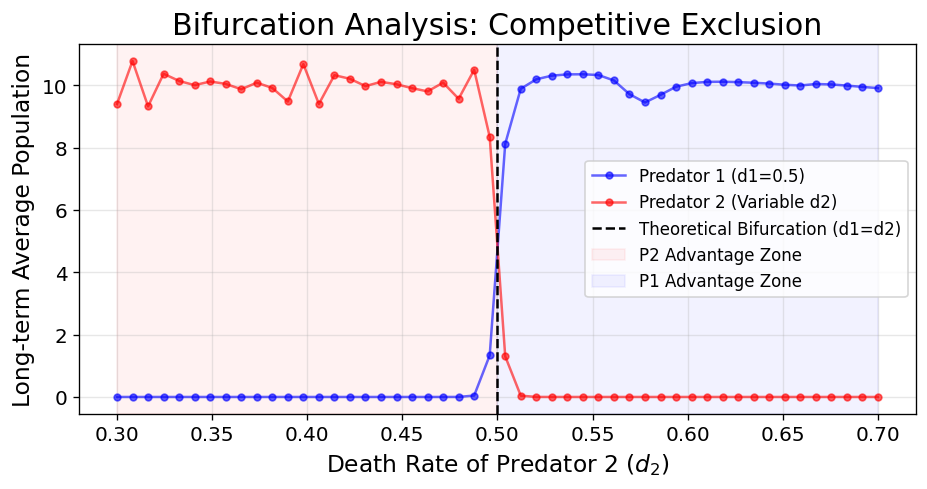

In [31]:
# Bifurcation Loop
d2_values = np.linspace(0.3, 0.7, 50)
p1_final_avgs = []
p2_final_avgs = []

# Fixed params: a=1.0, b1=b2=0.1, c1=c2=0.075, d1=0.5
base_params = [1.0, 0.1, 0.1, 0.075, 0.075, 0.5]

print("Running bifurcation analysis...")

for val_d2 in d2_values:
    # Combine base params with the changing d2
    current_params = base_params + [val_d2]

    # Run long simulation
    sol = run_simulation(extended_predator_prey, current_params, time_span=(0, 500))

    # Average the last 20% of the trajectory to capture steady-state behavior
    # (avoiding initial transients)
    n_points = len(sol.t)
    last_idx = int(n_points * 0.8)

    p1_avg = np.mean(sol.y[1][last_idx:])
    p2_avg = np.mean(sol.y[2][last_idx:])

    p1_final_avgs.append(p1_avg)
    p2_final_avgs.append(p2_avg)

# Plot Bifurcation Diagram
plt.figure(figsize=(9, 4))
plt.plot(d2_values, p1_final_avgs, 'b-o', label='Predator 1 (d1=0.5)', markersize=4, alpha=0.6)
plt.plot(d2_values, p2_final_avgs, 'r-o', label='Predator 2 (Variable d2)', markersize=4, alpha=0.6)

# Add marker for the theoretical switch point
plt.axvline(x=0.5, color='k', linestyle='--', label='Theoretical Bifurcation (d1=d2)')
plt.axvspan(0.3, 0.5, color='red', alpha=0.05, label='P2 Advantage Zone')
plt.axvspan(0.5, 0.7, color='blue', alpha=0.05, label='P1 Advantage Zone')

plt.title("Bifurcation Analysis: Competitive Exclusion", fontsize=18, fontweight=18)
plt.xlabel("Death Rate of Predator 2 ($d_2$)", fontsize=14)
plt.ylabel("Long-term Average Population", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Let's plot initial conditions near the trivial solution to check for it's stability behavior, in both scenarios.

Running near-origin dynamics simulations...
Initial Conditions: [(-1, -1, -1), (-1, -1, 1), (-1, 1, -1), (-1, 1, 1), (1, -1, -1), (1, -1, 1), (1, 1, -1), (1, 1, 1), [20, 15, 15], [10, 30, 30]]


/tmp/ipython-input-1786836577.py:8: RuntimeWarning: overflow encountered in scalar multiply
  dHdt  = a * H - b1 * H * P1 - b2 * H * P2
/tmp/ipython-input-1786836577.py:10: RuntimeWarning: overflow encountered in scalar multiply
  dP2dt = c2 * H * P2 - d2 * P2
/tmp/ipython-input-1786836577.py:10: RuntimeWarning: invalid value encountered in scalar subtract
  dP2dt = c2 * H * P2 - d2 * P2
/tmp/ipython-input-1786836577.py:8: RuntimeWarning: overflow encountered in scalar subtract
  dHdt  = a * H - b1 * H * P1 - b2 * H * P2
/tmp/ipython-input-1786836577.py:9: RuntimeWarning: invalid value encountered in scalar subtract
  dP1dt = c1 * H * P1 - d1 * P1
/tmp/ipython-input-1786836577.py:8: RuntimeWarning: invalid value encountered in scalar subtract
  dHdt  = a * H - b1 * H * P1 - b2 * H * P2


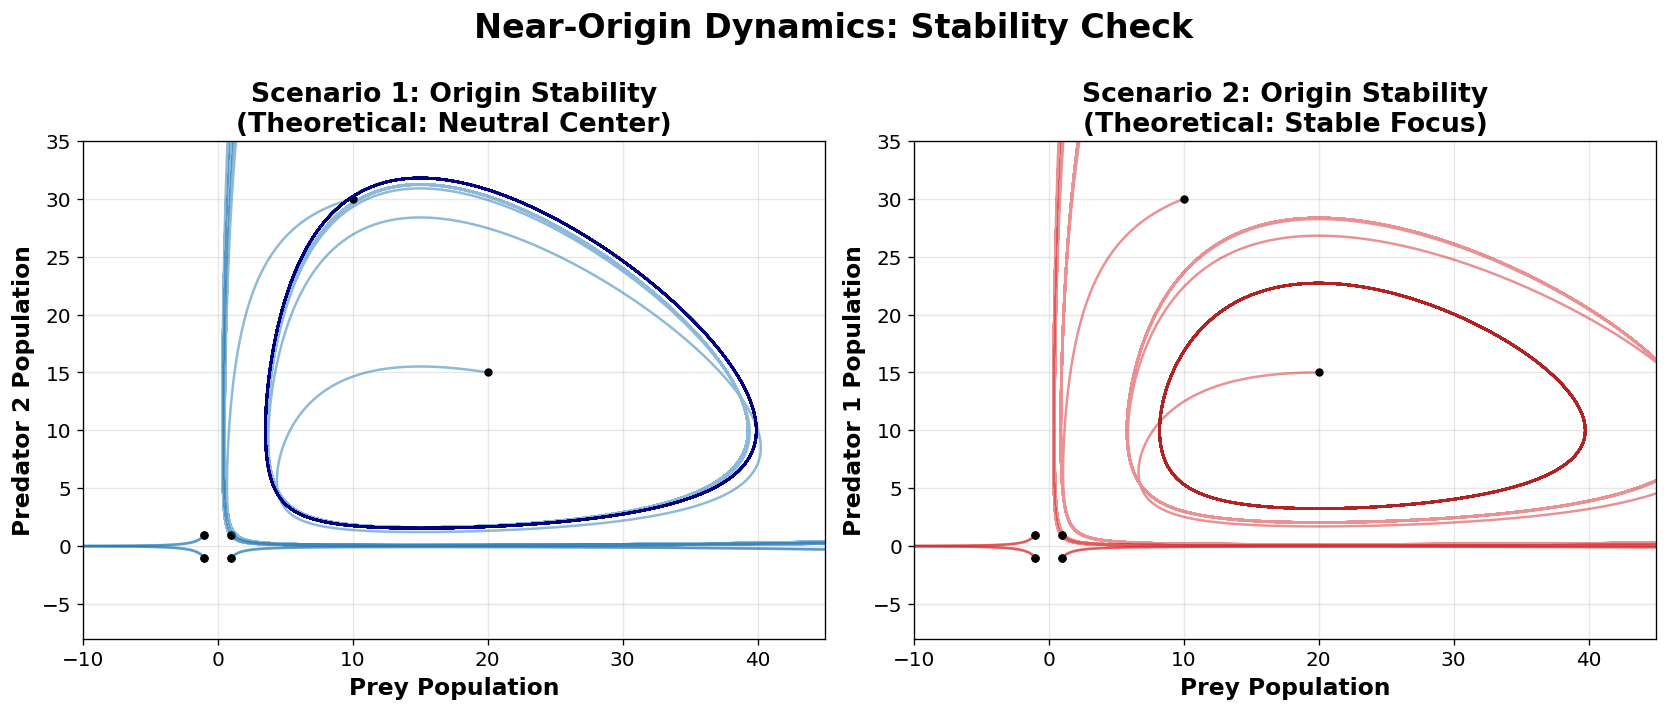

In [38]:
# ---------------------------------------------------------
# NEAR-ORIGIN DYNAMICS
# ---------------------------------------------------------
import itertools

# 1. Define Parameters (Consistent with previous analysis)
# Scenario 1: P2 grows faster (c2=0.10) -> Origin should be Neutral Center
params_sc1 = [1.0, 0.1, 0.1, 0.075, 0.10, 1.5, 1.5]

# Scenario 2: P2 dies faster (d2=2) -> Origin should be Stable Focus
params_sc2 = [1.0, 0.1, 0.1, 0.075, 0.075, 1.5, 2]

# 2. Generate Initial Conditions (Corners of a small cube around origin)
# We test points like (0.5, 0.5, 0.5), (0.5, 0.5, 1.0), etc.
delta = 1
initial_conditions = list(itertools.product([-delta, delta], repeat=3))
# add more initial conditions:
# [20, 15, 15]
# [10, 30, 30]
initial_conditions.append([20, 15, 15])
initial_conditions.append([10, 30, 30])


# 3. Run Simulations
trajs_sc1 = []
trajs_sc2 = []
t_span_check = (0, 100) # Short duration to observe local stability

# print running simulations for this initial conditions
print("Running near-origin dynamics simulations...")
print("Initial Conditions:", initial_conditions)

for y0_local in initial_conditions:
    # Run simulation for Scenario 1
    s1 = run_simulation(extended_predator_prey, params_sc1,
                        time_span=t_span_check, y0=y0_local)
    trajs_sc1.append(s1)

    # Run simulation for Scenario 2
    s2 = run_simulation(extended_predator_prey, params_sc2,
                        time_span=t_span_check, y0=y0_local)
    trajs_sc2.append(s2)

# 4. Plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Styling Constants
TITLE_SIZE = 20
SUBTITLE_SIZE = 16
LABEL_SIZE = 14
TICK_SIZE = 12

fig.suptitle("Near-Origin Dynamics: Stability Check", fontsize=TITLE_SIZE, fontweight='bold')

def style_ax(ax, title, xlabel, ylabel):
    ax.set_title(title, fontsize=SUBTITLE_SIZE, fontweight='bold')
    ax.set_xlabel(xlabel, fontsize=LABEL_SIZE, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=LABEL_SIZE, fontweight='bold')
    ax.tick_params(axis='both', labelsize=TICK_SIZE)
    ax.grid(alpha=0.3)

# --- PLOT SCENARIO 1 (P2 Grows Faster) ---
# Expectation: Neutral Center behavior (cycles)
for sol in trajs_sc1:
    axs[0].plot(sol.y[0], sol.y[2], '-', alpha=0.5, color='tab:blue')
    axs[0].plot(sol.y[0][0], sol.y[2][0], 'ko', markersize=4) # Start point
# plot the limit cycle. We take the last point from sol1 variable and run a new simulation
point_limit_cycle_sc1 = sol1.y[:,-1]
limit_cycle_sc1 = run_simulation(extended_predator_prey, params_sc1, time_span=(0, 100), y0=point_limit_cycle_sc1)
axs[0].plot(limit_cycle_sc1.y[0], limit_cycle_sc1.y[2], '-', color='navy')

style_ax(axs[0], "Scenario 1: Origin Stability\n(Theoretical: Neutral Center)", "Prey Population", "Predator 2 Population")
axs[0].set_xlim(-10, 45)
axs[0].set_ylim(-8, 35)

# --- PLOT SCENARIO 2 (P2 Dies Faster) ---
# Expectation: Stable Focus (spirals in)
for sol in trajs_sc2:
    axs[1].plot(sol.y[0], sol.y[1], '-', alpha=0.5, color='tab:red')
    axs[1].plot(sol.y[0][0], sol.y[1][0], 'ko', markersize=4) # Start point
# plot limit cycle
point_limit_cycle_sc2 = sol2.y[:,-1]
limit_cycle_sc2 = run_simulation(extended_predator_prey, params_sc2, time_span=(0, 100), y0=point_limit_cycle_sc2)
axs[1].plot(limit_cycle_sc2.y[0], limit_cycle_sc2.y[1], '-', color='firebrick')

style_ax(axs[1], "Scenario 2: Origin Stability\n(Theoretical: Stable Focus)", "Prey Population", "Predator 1 Population")
axs[1].set_xlim(-10, 45)
axs[1].set_ylim(-8, 35)

plt.tight_layout()
plt.subplots_adjust(top=0.8) # Adjust for main title
plt.show()


Simulating 512 trajectories per scenario...


/tmp/ipython-input-1786836577.py:8: RuntimeWarning: overflow encountered in scalar multiply
  dHdt  = a * H - b1 * H * P1 - b2 * H * P2
/tmp/ipython-input-1786836577.py:10: RuntimeWarning: overflow encountered in scalar multiply
  dP2dt = c2 * H * P2 - d2 * P2
/tmp/ipython-input-1786836577.py:10: RuntimeWarning: invalid value encountered in scalar subtract
  dP2dt = c2 * H * P2 - d2 * P2
/usr/local/lib/python3.12/dist-packages/scipy/integrate/_ivp/lsoda.py:161: UserWarning: lsoda: Excess accuracy requested (tolerances too small).
  solver._y, solver.t = integrator.run(
/tmp/ipython-input-1786836577.py:8: RuntimeWarning: overflow encountered in scalar subtract
  dHdt  = a * H - b1 * H * P1 - b2 * H * P2
/tmp/ipython-input-1786836577.py:9: RuntimeWarning: invalid value encountered in scalar subtract
  dP1dt = c1 * H * P1 - d1 * P1
/tmp/ipython-input-1786836577.py:8: RuntimeWarning: invalid value encountered in scalar subtract
  dHdt  = a * H - b1 * H * P1 - b2 * H * P2


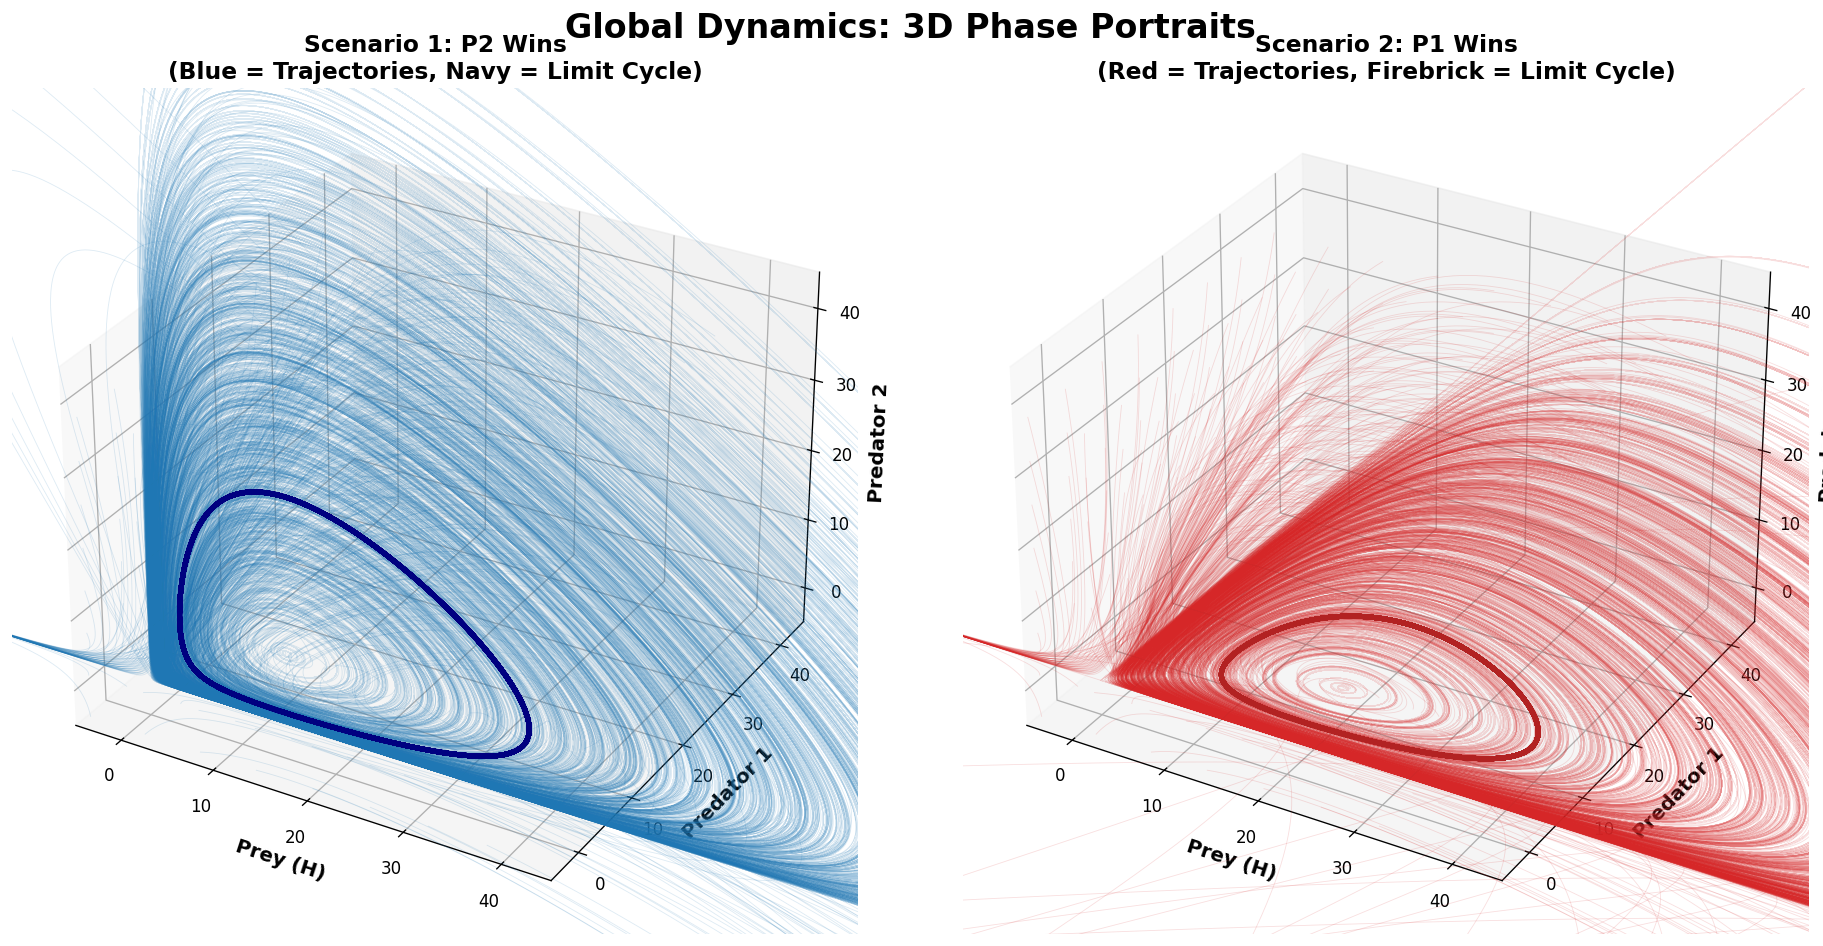

In [149]:
# ---------------------------------------------------------
# 3D PHASE PORTRAIT: GLOBAL DYNAMICS
# ---------------------------------------------------------
import itertools
from mpl_toolkits.mplot3d import Axes3D

# 1. Define Parameters
params_sc1 = [1.0, 0.1, 0.1, 0.075, 0.10, 1.5, 1.5] # Sc 1: P2 grows faster
params_sc2 = [1.0, 0.1, 0.1, 0.075, 0.075, 1.5, 2] # Sc 2: P2 dies faster

# 2. Generate Initial Conditions (Grid)
# Note: Populations cannot be negative mathematically in this biological context.
# While the math allows negative inputs, it's biologically meaningless.

values = np.arange(-4, 42, 6) # Coarser step (6) to avoid overcrowding the plot (8^3 = 512 lines!)
# Let's stick to a manageable number for visualization.
initial_conditions = list(itertools.product(values, repeat=3))

print(f"Simulating {len(initial_conditions)} trajectories per scenario...")

# 3. Run Simulations
trajs_sc1 = []
trajs_sc2 = []
t_span_check = (0, 100) # Moderate duration

for y0_local in initial_conditions:
    s1 = run_simulation(extended_predator_prey, params_sc1, time_span=t_span_check, y0=y0_local)
    trajs_sc1.append(s1)

    s2 = run_simulation(extended_predator_prey, params_sc2, time_span=t_span_check, y0=y0_local)
    trajs_sc2.append(s2)

# Limit Cycles (Reference)
lc_sc1 = run_simulation(extended_predator_prey, params_sc1, (0, 100), y0=sol1.y[:,-1])
lc_sc2 = run_simulation(extended_predator_prey, params_sc2, (0, 100), y0=sol2.y[:,-1])


# 4. Plotting (3D)
fig = plt.figure(figsize=(16, 8))
fig.suptitle("Global Dynamics: 3D Phase Portraits", fontsize=20, fontweight='bold')

# --- SUBPLOT 1: SCENARIO 1 (P2 Wins) ---
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_title("Scenario 1: P2 Wins\n(Blue = Trajectories, Navy = Limit Cycle)", fontsize=14, fontweight='bold')

# Plot trajectories
for sol in trajs_sc1:
    ax1.plot(sol.y[0], sol.y[1], sol.y[2], color='tab:blue', alpha=0.15, linewidth=0.5)

# Plot Limit Cycle
ax1.plot(lc_sc1.y[0], lc_sc1.y[1], lc_sc1.y[2], color='navy', linewidth=3, label='Limit Cycle')

# Labels
ax1.set_xlabel('Prey (H)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Predator 1', fontsize=12, fontweight='bold')
ax1.set_zlabel('Predator 2', fontsize=12, fontweight='bold')
ax1.set_xlim(-5, 45)
ax1.set_ylim(-5, 45)
ax1.set_zlim(-5, 45)

# --- SUBPLOT 2: SCENARIO 2 (P1 Wins) ---
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_title("Scenario 2: P1 Wins\n(Red = Trajectories, Firebrick = Limit Cycle)", fontsize=14, fontweight='bold')

# Plot trajectories
for sol in trajs_sc2:
    ax2.plot(sol.y[0], sol.y[1], sol.y[2], color='tab:red', alpha=0.15, linewidth=0.5)

# Plot Limit Cycle
ax2.plot(lc_sc2.y[0], lc_sc2.y[1], lc_sc2.y[2], color='firebrick', linewidth=3, label='Limit Cycle')

# Labels
ax2.set_xlabel('Prey (H)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Predator 1', fontsize=12, fontweight='bold')
ax2.set_zlabel('Predator 2', fontsize=12, fontweight='bold')
ax2.set_xlim(-5, 45)
ax2.set_ylim(-5, 45)
ax2.set_zlim(-5, 45)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

let's try to plot the last 20 time units

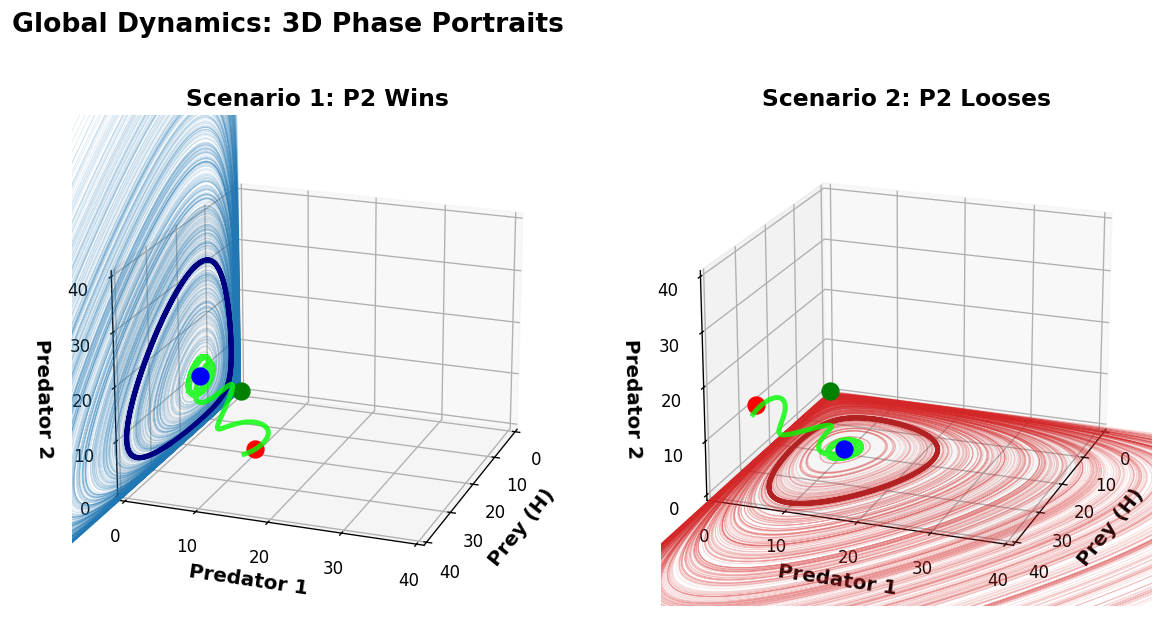

In [150]:
# 4. Plotting (3D)
fig = plt.figure(figsize=(12, 6))
fig.suptitle("Global Dynamics: 3D Phase Portraits", fontsize=16, fontweight='bold')
last_10_percent_points = int(len(sol.y[0]) * 0.9)

# --- SUBPLOT 1: SCENARIO 1 (P2 Wins) ---
ax1 = fig.add_subplot(121, projection='3d')
# custom rotation
ax1.view_init(elev=20, azim=20)
ax1.set_title("Scenario 1: P2 Wins", fontsize=14, fontweight='bold')

# Plot trajectories
for sol in trajs_sc1:
    ax1.plot(sol.y[0][last_10_percent_points:],
             sol.y[1][last_10_percent_points:],
             sol.y[2][last_10_percent_points:], color='tab:blue', alpha=0.15, linewidth=0.5, zorder=1)

# Plot Limit Cycle
ax1.plot(lc_sc1.y[0][last_10_percent_points:],
         lc_sc1.y[1][last_10_percent_points:],
         lc_sc1.y[2][last_10_percent_points:], color='navy', linewidth=3, label='Limit Cycle', zorder=1)

# add the theoretical steady states
# (0, 0, 0) in green
ax1.plot(0, 0, 0, 'go', markersize=10, zorder=1)
# (20, 10, 0) in red
ax1.plot(20, 10, 0, 'ro', markersize=10, zorder=1)
# (15, 0, 10) in blue
ax1.plot(15, 0, 10, 'bo', markersize=10, zorder=3)

sol_test = run_simulation(extended_predator_prey, params_sc1, (0, 1000), y0=[24, 10, 1])
ax1.plot(sol_test.y[0], sol_test.y[1], sol_test.y[2],color='lime', linewidth=3, label='Test', zorder=2, alpha=0.8)


# Labels
ax1.set_xlabel('Prey (H)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Predator 1', fontsize=12, fontweight='bold')
ax1.set_zlabel('Predator 2', fontsize=12, fontweight='bold')
ax1.set_xlim(-1, 41)
ax1.set_ylim(-1, 41)
ax1.set_zlim(-1, 41)
# ticks from 0 to 40 with step 10
ax1.set_xticks(np.arange(0, 41, 10))
ax1.set_yticks(np.arange(0, 41, 10))
ax1.set_zticks(np.arange(0, 41, 10))

# --- SUBPLOT 2: SCENARIO 2 (P1 Wins) ---
ax2 = fig.add_subplot(122, projection='3d')
# custom rotation
ax2.view_init(elev=20, azim=20)
ax2.set_title("Scenario 2: P2 Looses", fontsize=14, fontweight='bold')

# Plot trajectories
for sol in trajs_sc2:
    ax2.plot(sol.y[0][last_10_percent_points:],
             sol.y[1][last_10_percent_points:],
             sol.y[2][last_10_percent_points:],
             color='tab:red', alpha=0.15, linewidth=0.5, zorder=1)

# Plot Limit Cycle
ax2.plot(lc_sc2.y[0][last_10_percent_points:],
         lc_sc2.y[1][last_10_percent_points:],
         lc_sc2.y[2][last_10_percent_points:], color='firebrick', linewidth=3, label='Limit Cycle', zorder=1)

# add the theoretical steady states
#(0, 0, 0)
ax2.plot(0, 0, 0, 'go', markersize=10, zorder=1)
#(20, 10, 0)
ax2.plot(20, 10, 0, 'bo', markersize=10, zorder=3)
#(26.667, 0, 10)
ax2.plot(26.667, 0, 10, 'ro', markersize=10, zorder=1)

sol_test = run_simulation(extended_predator_prey, params_sc2, (0, 1000), y0=[30, 1, 10])
ax2.plot(sol_test.y[0], sol_test.y[1], sol_test.y[2],color='lime', linewidth=3, label='Test', zorder=2, alpha=0.8)


# Labels
ax2.set_xlabel('Prey (H)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Predator 1', fontsize=12, fontweight='bold')
ax2.set_zlabel('Predator 2', fontsize=12, fontweight='bold')
ax2.set_xlim(-1, 41)
ax2.set_ylim(-1, 41)
ax2.set_zlim(-1, 41)
# ticks from 0 to 40 with step 10
ax2.set_xticks(np.arange(0, 41, 10))
ax2.set_yticks(np.arange(0, 41, 10))
ax2.set_zticks(np.arange(0, 41, 10))

#Increase space between suptitle and titles
#plt.subplots_adjust(top=0.7)
#increase space between titles and subplots
#plt.subplots_adjust(wspace=0.2)

#plt.subplots_adjust(right=0.8)
# decrese space between subplots
# plt.subplots_adjust(wspace=-0.1)
# increase space between left limit of the figure and left subplot
plt.subplots_adjust(left=0.35)
plt.subplots_adjust(right=1.1)
#plt.tight_layout()
plt.show()

It is actually not a stable steady state but a neutral center as well!!

## 5. Sensitivity Analysis

We perform a Global Sensitivity Analysis (Sobol Method) to determine which parameters most strongly affect the success of the second predator (measured by its **maximum population** reached).

### Sensitivity analysis of the original model

In [17]:
# ---------------------------------------------------------
# SENSITIVITY ANALYSIS: ORIGINAL MODEL
# ---------------------------------------------------------

# Define the problem for SALib
problem_orig = {
    'num_vars': 4,
    'names': ['a', 'b', 'c', 'd'],
    'bounds': [[0.5, 1.5],   # a: Prey growth
               [0.05, 0.15], # b: Predation
               [0.05, 0.1],  # c: Predator reproduction
               [1.0, 2.0]]   # d: Predator death
}

# Generate samples (N=1000 is good, total samples = N*(2D+2) = 10000)
# Note: calc_second_order=False by default in older SALib, but Saltelli usually assumes True.
# We'll use a slightly lower N=512 if speed is an issue, or keep 1000 if you have time.
num_samples = 512
param_values_orig = saltelli.sample(problem_orig, num_samples)

# Simulation settings
H0, P0 = 40, 9
tmax = 150
timepoints_per_unit = 50
# CRITICAL: Define strict time evaluation to ensure -5000 implies 50 time units
t_eval = np.linspace(0, tmax, tmax*timepoints_per_unit) # 100 points per time unit. Total 20000 points.

# Storage
Y_orig_P = np.zeros([param_values_orig.shape[0]])
Y_orig_H = np.zeros([param_values_orig.shape[0]])

print(f"Running Original Sensitivity Analysis on {len(Y_orig_P)} samples...")

# Run Loop
for i, (a, b, c, d) in enumerate(param_values_orig):
    # We pass t_eval explicitly to control the output density
    sol = solve_ivp(original_predator_prey, [0, tmax], [H0, P0],
                    args=(a, b, c, d),
                    t_eval=t_eval, method='LSODA')

    # Robust metric: Mean of P over the last 50 time units
    # Since we have 50 pts/unit, 50 units = 2500 points
    if sol.success and len(sol.y[1]) >= 50*timepoints_per_unit:
        Y_orig_P[i] = np.mean(sol.y[1][-50*timepoints_per_unit:])
        Y_orig_H[i] = np.mean(sol.y[0][-50*timepoints_per_unit:])
    else:
        Y_orig_P[i] = 0 # Handle failures or too short runs
        Y_orig_H[i] = 0

# Analyze
Si_orig_P = sobol.analyze(problem_orig, Y_orig_P, print_to_console=True)
Si_orig_H = sobol.analyze(problem_orig, Y_orig_H, print_to_console=True)


/tmp/ipython-input-3270133104.py:19: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values_orig = saltelli.sample(problem_orig, num_samples)


Running Original Sensitivity Analysis on 5120 samples...
         ST   ST_conf
a  0.469464  0.068790
b  0.574336  0.077406
c  0.001877  0.000331
d  0.001920  0.000443
         S1   S1_conf
a  0.414347  0.080581
b  0.531897  0.100342
c -0.001758  0.004745
d -0.000527  0.005618
              S2   S2_conf
(a, b)  0.056173  0.152485
(a, c)  0.006537  0.106352
(a, d)  0.007925  0.106502
(b, c) -0.001520  0.176544
(b, d) -0.000287  0.175841
(c, d)  0.000875  0.007817
         ST   ST_conf
a  0.002319  0.000388
b  0.001884  0.000411
c  0.530771  0.055344
d  0.489778  0.061196
         S1   S1_conf
a -0.002806  0.005918
b -0.003196  0.004674
c  0.513816  0.086870
d  0.465321  0.078270
              S2   S2_conf
(a, b) -0.000651  0.009366
(a, c)  0.003729  0.007843
(a, d)  0.003866  0.009420
(b, c)  0.006831  0.006216
(b, d)  0.004554  0.007295
(c, d)  0.027130  0.165492


### Sensitivity analysis of extended model

In [18]:
# ---------------------------------------------------------
# SENSITIVITY ANALYSIS: EXTENDED MODEL
# ---------------------------------------------------------

# Define problem
problem_ext = {
    'num_vars': 7,
    'names': ['a', 'b1', 'b2', 'c1', 'c2', 'd1', 'd2'],
    'bounds': [[0.5, 1.5],   # a
               [0.05, 0.15], # b1
               [0.05, 0.15], # b2
               [0.05, 0.1],  # c1
               [0.05, 0.1],  # c2
               [1.0, 2.0],   # d1
               [1.0, 2.0]]   # d2
}

# Generate samples
param_values_ext = saltelli.sample(problem_ext, num_samples)

# Storage
Y_ext_P = np.zeros([param_values_ext.shape[0]])
Y_ext_H = np.zeros([param_values_ext.shape[0]])

print(f"Running Extended Sensitivity Analysis on {len(Y_ext_P)} samples...")

# Run Loop
for i, (a, b1, b2, c1, c2, d1, d2) in enumerate(param_values_ext):
    sol = solve_ivp(extended_predator_prey, [0, tmax], [40, 9, 9],
                    args=(a, b1, b2, c1, c2, d1, d2),
                    t_eval=t_eval, method='LSODA')

    # Metric: Mean of P1 (Predator 1) over last 50 time units
    if sol.success and len(sol.y[1]) >= 50*timepoints_per_unit:
        Y_ext_P[i] = np.mean(sol.y[1][-50*timepoints_per_unit:])
        Y_ext_H[i] = np.mean(sol.y[0][-50*timepoints_per_unit:])
    else:
        Y_ext_P[i] = 0
        Y_ext_H[i] = 0

# Analyze
Si_ext_P = sobol.analyze(problem_ext, Y_ext_P, print_to_console=True)
Si_ext_H = sobol.analyze(problem_ext, Y_ext_H, print_to_console=True)


Running Extended Sensitivity Analysis on 8192 samples...


/tmp/ipython-input-1141234777.py:19: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values_ext = saltelli.sample(problem_ext, num_samples)


          ST   ST_conf
a   0.143942  0.028956
b1  0.172643  0.036550
b2  0.000599  0.000175
c1  0.402110  0.096669
c2  0.408268  0.083592
d1  0.437348  0.092492
d2  0.392182  0.098604
          S1   S1_conf
a   0.082856  0.053758
b1  0.065777  0.061291
b2  0.000994  0.002989
c1  0.157200  0.067124
c2  0.121858  0.076717
d1  0.193914  0.086057
d2  0.148546  0.073890
                S2   S2_conf
(a, b1)  -0.028027  0.103922
(a, b2)  -0.030845  0.092730
(a, c1)  -0.043071  0.090986
(a, c2)  -0.044492  0.084968
(a, d1)  -0.027124  0.085247
(a, d2)  -0.016992  0.082569
(b1, b2)  0.017106  0.097610
(b1, c1)  0.008300  0.092719
(b1, c2)  0.015037  0.089002
(b1, d1)  0.048980  0.093917
(b1, d2)  0.000372  0.099922
(b2, c1) -0.000111  0.003899
(b2, c2) -0.000721  0.003593
(b2, d1) -0.000002  0.004021
(b2, d2)  0.001001  0.003989
(c1, c2) -0.032449  0.098139
(c1, d1) -0.096128  0.090221
(c1, d2) -0.067052  0.096736
(c2, d1) -0.052970  0.102048
(c2, d2)  0.001740  0.122416
(d1, d2) -0.064122  0.0

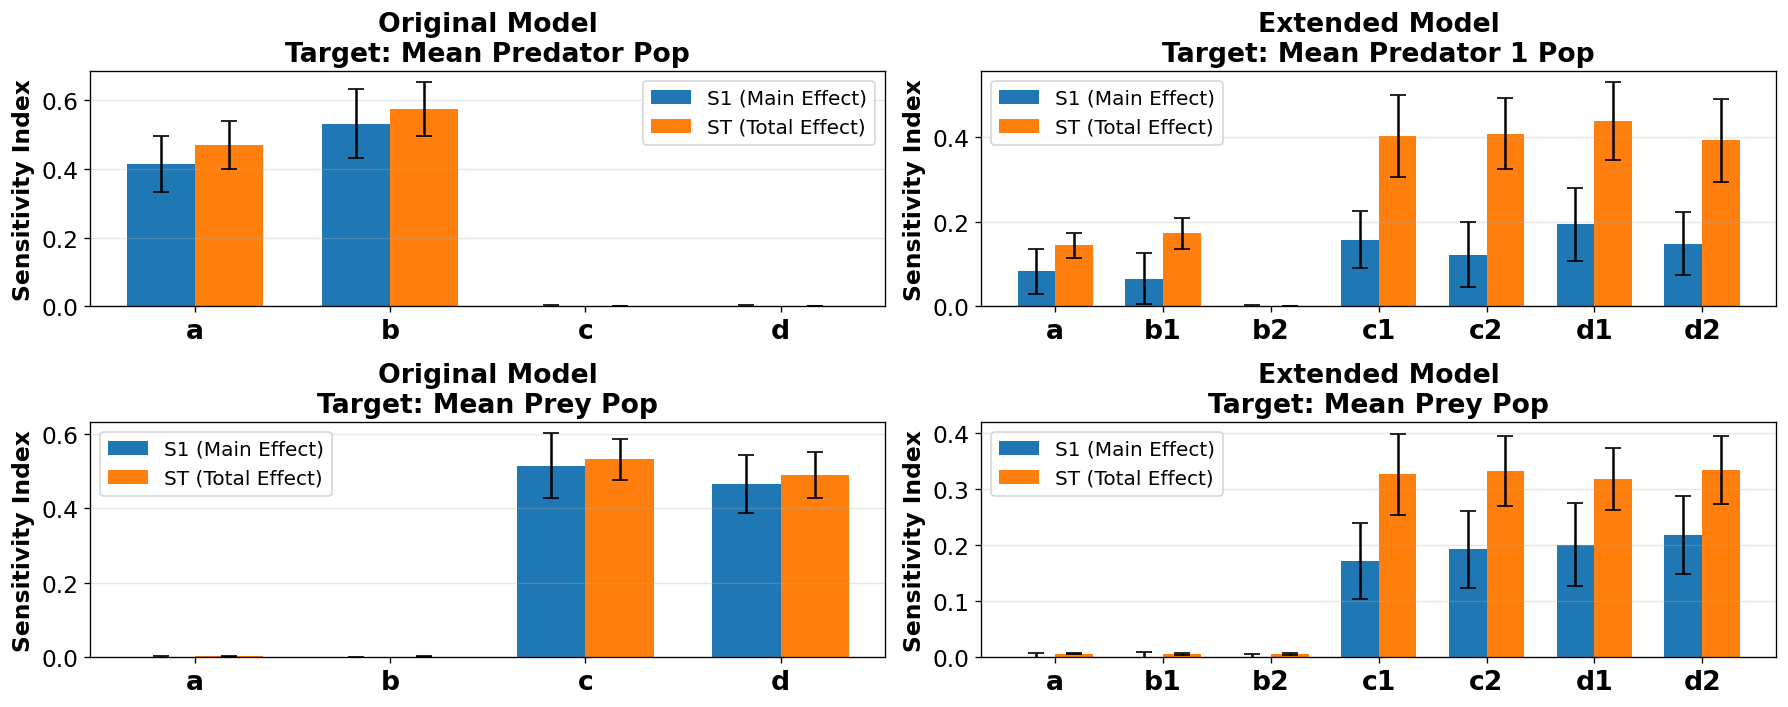

In [146]:
# ---------------------------------------------------------
# PLOTTING SENSITIVITY INDICES
# ---------------------------------------------------------

def plot_sobol(ax, indices, problem, title):
    labels = problem['names']
    # Use array conversion for safe indexing
    S1 = np.array(indices['S1'])
    ST = np.array(indices['ST'])
    # Optional: Error bars (confidence intervals)
    S1_conf = np.array(indices['S1_conf'])
    ST_conf = np.array(indices['ST_conf'])

    x = np.arange(len(labels))
    width = 0.35

    rects1 = ax.bar(x - width/2, S1, width, yerr=S1_conf, capsize=5, label='S1 (Main Effect)')
    rects2 = ax.bar(x + width/2, ST, width, yerr=ST_conf, capsize=5, label='ST (Total Effect)')

    ax.set_ylabel('Sensitivity Index', fontsize=14, fontweight='bold')
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=16, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    ax.legend(fontsize='large')
    # Dynamic ylim to fit data properly, but keeping 0 as floor
    ax.set_ylim(bottom=0)
    ax.grid(axis='y', alpha=0.3)

# Create 2-subplot figure (Side by Side)
fig, axes = plt.subplots(2, 2, figsize=(15, 6))

plot_sobol(axes[0,0], Si_orig_P, problem_orig, 'Original Model\nTarget: Mean Predator Pop')
plot_sobol(axes[0,1], Si_ext_P, problem_ext, 'Extended Model\nTarget: Mean Predator 1 Pop')
plot_sobol(axes[1,0], Si_orig_H, problem_orig, 'Original Model\nTarget: Mean Prey Pop')
plot_sobol(axes[1,1], Si_ext_H, problem_ext, 'Extended Model\nTarget: Mean Prey Pop')

plt.tight_layout()
plt.show()


### Conclusion of Bifurcation
The plot clearly demonstrates a **transcritical bifurcation** at $d_2 \approx 0.5$.
1.  **Left ($d_2 < 0.5$):** P2 dies slower than P1. P2 outcompetes P1. The red line is high, blue line is zero.
2.  **Right ($d_2 > 0.5$):** P2 dies faster than P1. P1 outcompetes P2. The blue line is high, red line is zero.
3.  **Point ($d_2 = 0.5$):** Coexistence is theoretically possible (neutrally stable manifold), but unstable to perturbations.